In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr


In [ ]:
from google.colab import files
files.upload()

Saving TrashType_Image_Dataset.zip to TrashType_Image_Dataset.zip
Buffered data was truncated after reaching the output size limit.

In [18]:
import zipfile

with zipfile.ZipFile("TrashType_Image_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [20]:
os.listdir("/content/TrashType_Image_Dataset")


['cardboard', 'glass', 'plastic', 'trash', 'metal', 'paper']

In [41]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


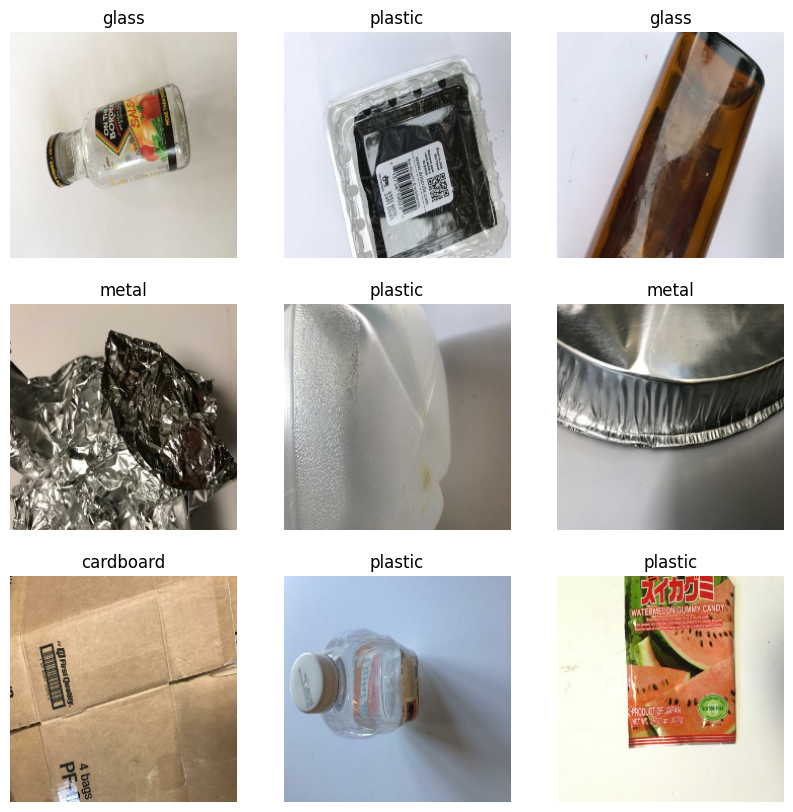

In [42]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [44]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [45]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def preprocess(image, label):
    return preprocess_input(image), label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)


In [46]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)
base_model.trainable = False  # Use pretrained weights only

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])


In [47]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.6379 - loss: 0.9825 - val_accuracy: 0.8812 - val_loss: 0.3396
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.8784 - loss: 0.3816 - val_accuracy: 0.9030 - val_loss: 0.2846
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.9026 - loss: 0.2778 - val_accuracy: 0.9149 - val_loss: 0.2519
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9239 - loss: 0.2104 - val_accuracy: 0.8931 - val_loss: 0.2971
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.9382 - loss: 0.1951 - val_accuracy: 0.8970 - val_loss: 0.2879


In [48]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
model.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.8905 - loss: 0.2497


[0.24604445695877075, 0.90625]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

   cardboard       0.97      0.95      0.96        38
       glass       1.00      0.77      0.87        43
       metal       0.87      0.94      0.90        48
       paper       0.97      0.98      0.98        65
     plastic       0.78      0.93      0.85        42
       trash       0.83      0.75      0.79        20

    accuracy                           0.91       256
   macro avg       0.90      0.89      0.89       256
weighted avg       0.91      0.91      0.91       256



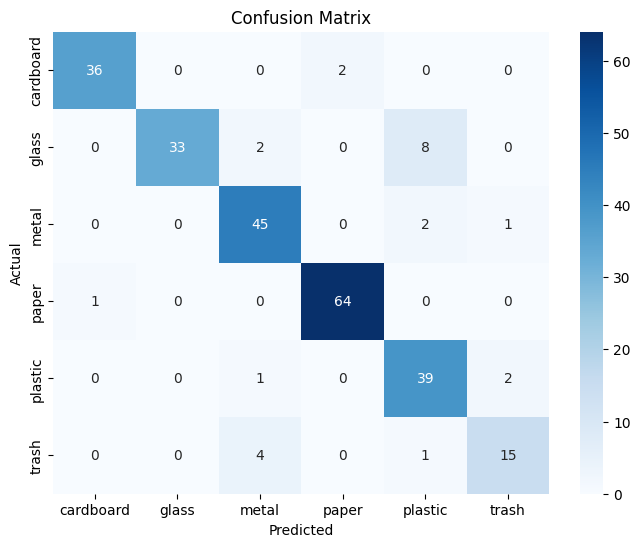

In [51]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [53]:
model.save("efficientnet_garbage_classifier.keras")
